# Advanced Lane Finding Project

The goals / steps of this project are the following:
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

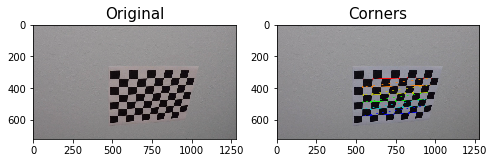

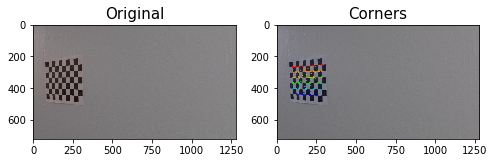

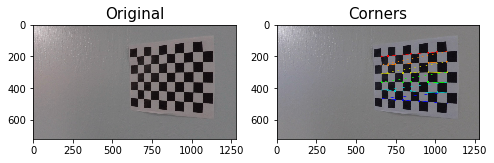

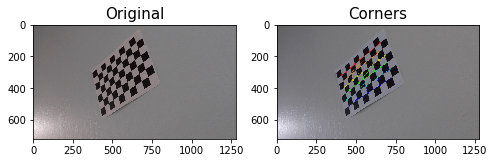

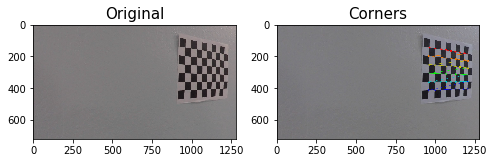

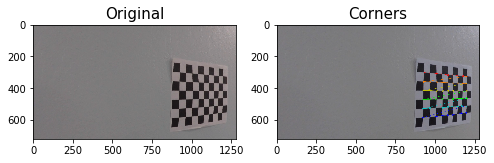

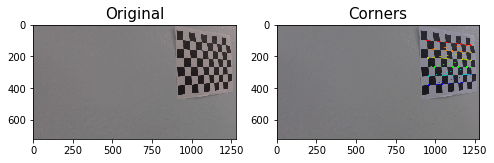

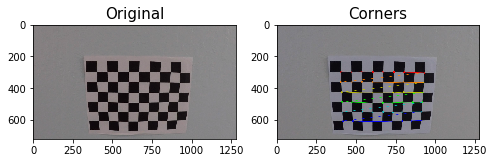

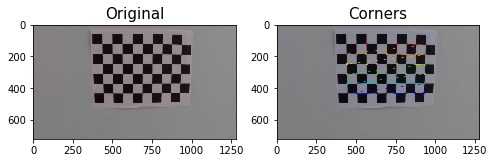

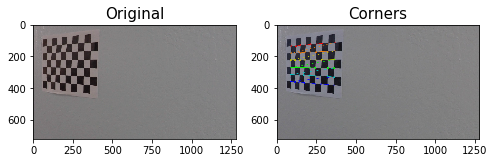

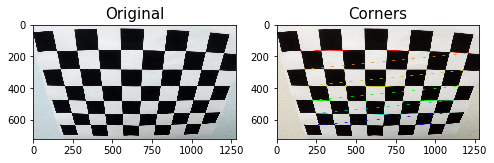

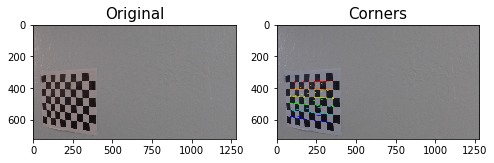

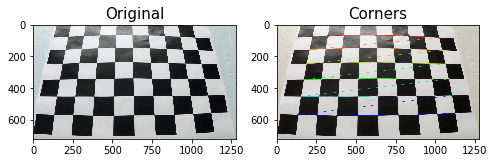

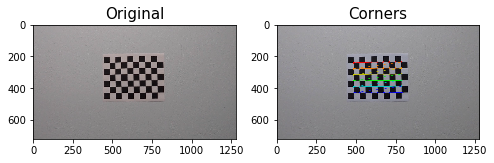

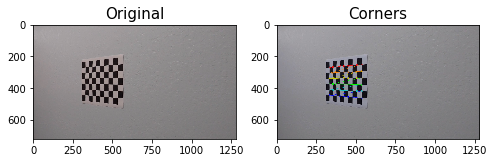

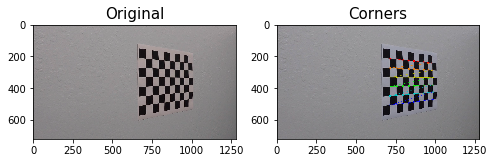

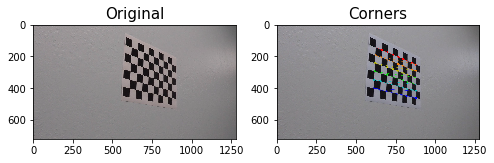

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (img1, img2) = plt.subplots(1, 2, figsize=(8,4))
        
        img1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        img1.set_title('Original', fontsize=15)
        
        img2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img2.set_title('Corners', fontsize=15)



Apply a distortion correction to raw images

In [3]:
# Remove distortion from images
def cal_undistort(image, show = True, read =True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (img1, img2) = plt.subplots(1, 2, figsize=(9,6))
        img1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img1.set_title('Original', fontsize=15)
        img2.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
        img2.set_title('Undistorted', fontsize=15)
    else:
        return undist_img

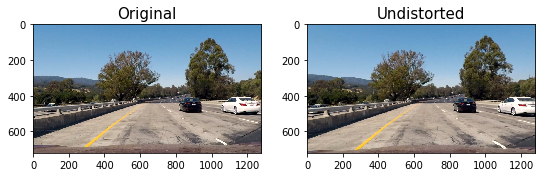

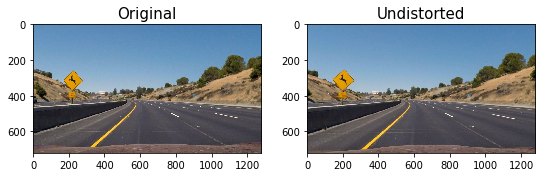

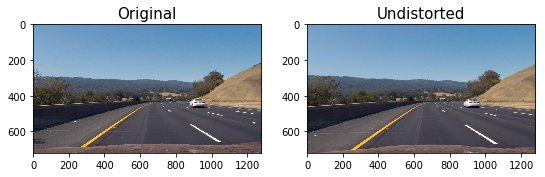

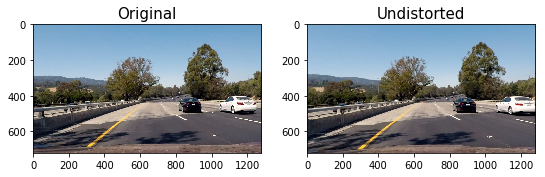

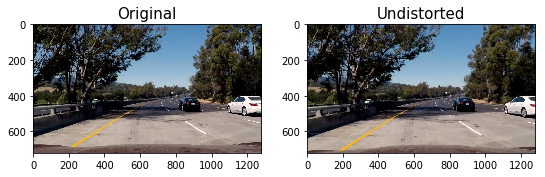

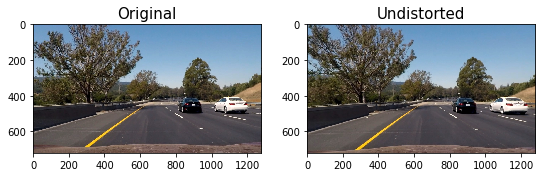

In [4]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    cal_undistort(image, True)

Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").

In [5]:
# Perform perspective transform
def unwarp(img, display = True, read = True):
    if read:
        undist = cal_undistort(img, False)
    else:
        undist = cal_undistort(img, False, False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (img1, img2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        img1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        img1.set_title('Undistorted', fontsize=15)
        img2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        img2.set_title('Undistorted and Warped', fontsize=15)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

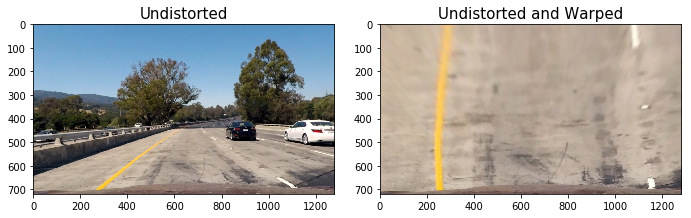

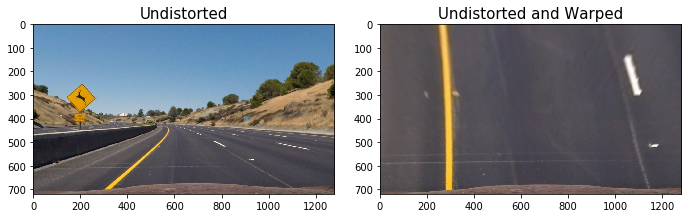

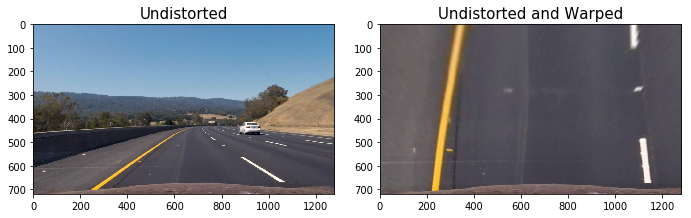

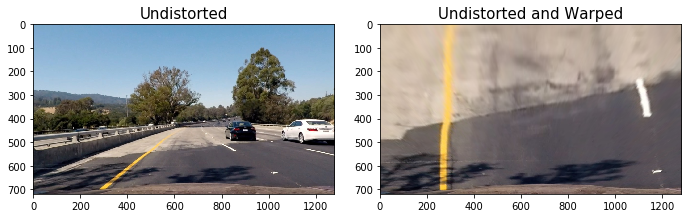

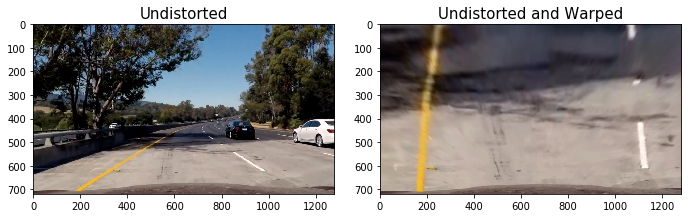

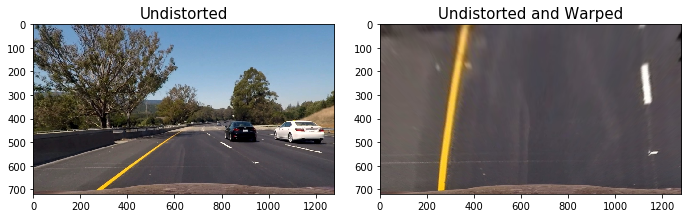

In [6]:
for image in glob.glob('test_images/test*.jpg'):
    unwarp(image)

In [7]:
# Create binary thresholded images to isolate lane line pixels
def set_thresholds(image, show = True):
    
    img, M = unwarp(image, display = False)

    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]  
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]

    # Threshold color channel
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    combined = np.zeros_like(s_binary)
    combined[(l_binary == 1) | (b_binary == 1)] = 1

    if show:
        # Plotting thresholded images
        f, ((img1, img2, img3), (img4,img5, img6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        img1.set_title('Original', fontsize=15)
        img1.imshow(cv2.cvtColor(cal_undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        img2.set_title('Warped', fontsize=15)
        img2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        img3.set_title('s_binary threshold', fontsize=15)
        img3.imshow(s_binary, cmap='gray')
        
        img4.set_title('b_binary threshold', fontsize=15)
        img4.imshow(b_binary, cmap='gray')
        
        img5.set_title('l_binary threshold', fontsize=15)
        img5.imshow(l_binary, cmap='gray')

        img6.set_title('Combined thresholds', fontsize=15)
        img6.imshow(combined, cmap='gray')
        
        
    else: 
        return combined

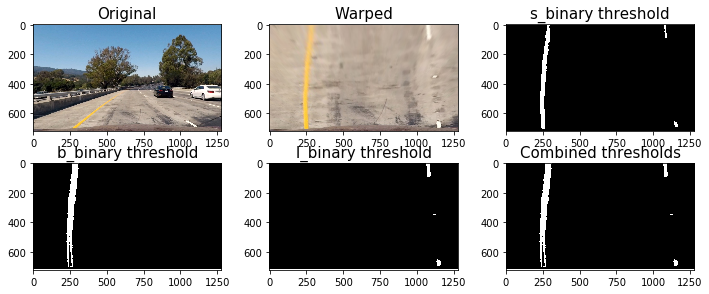

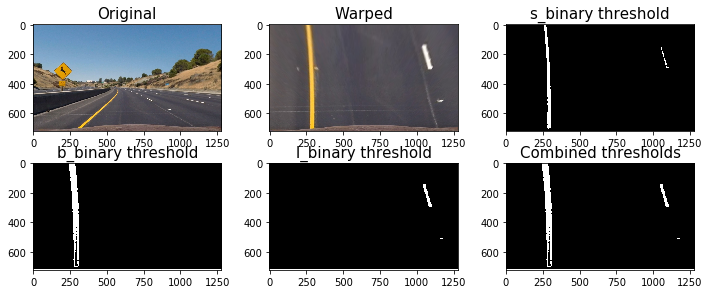

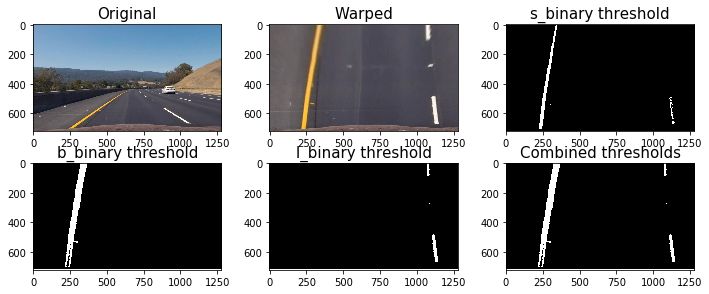

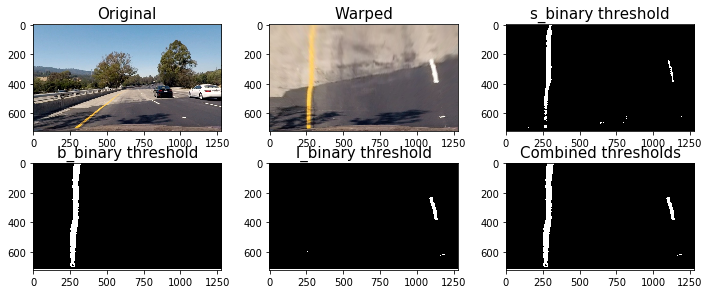

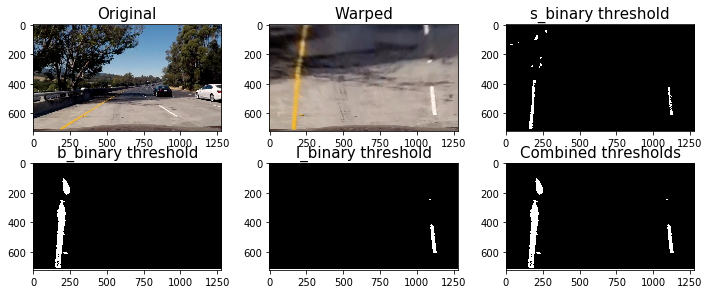

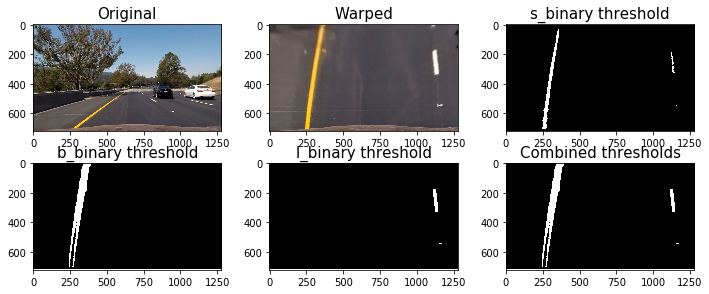

In [8]:
for image in glob.glob('test_images/test*.jpg'):
    set_thresholds(image)

Detect lane pixels and fit to find the lane boundary. Determine the curvature of the lane and vehicle position with respect to center. 

Warp the detected lane boundaries back onto the original image. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [9]:
def full_lane(image):
    
    combined = set_thresholds(image,False)
    
    right_x = []
    right_y = []
    left_x = []
    left_y = []
    
    x, y = np.nonzero(np.transpose(combined))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            left_x.extend(x_window.tolist())
            left_y.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            right_x.extend(x_window.tolist())
            right_y.extend(y_window.tolist())
        i -= 90
        j -= 90

    left_y = np.array(left_y).astype(np.float32)
    left_x = np.array(left_x).astype(np.float32)
    right_y = np.array(right_y).astype(np.float32)
    right_x = np.array(right_x).astype(np.float32)
    
    left_fit = np.polyfit(left_y, left_x, 2)
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    right_fit = np.polyfit(right_y, right_x, 2)
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    
    right_x = np.append(right_x,rightx_int)
    right_y = np.append(right_y, 720)
    right_x = np.append(right_x,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    right_y = np.append(right_y, 0)
    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    left_x = np.append(left_x, leftx_int)
    left_y = np.append(left_y, 720)
    left_x = np.append(left_x,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    left_y = np.append(left_y, 0)
    
    lsort = np.argsort(left_y)
    rsort = np.argsort(right_y)
    left_y = left_y[lsort]
    
    left_x = left_x[lsort]
    right_y = right_y[rsort]
    right_x = right_x[rsort]
    
    left_fit = np.polyfit(left_y, left_x, 2)
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    right_fit = np.polyfit(right_y, right_x, 2)
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(left_y) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(left_y) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, left_y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, right_y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined.shape[1], combined.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (img1, img2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    img1.imshow(cv2.cvtColor((unwarp(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    img1.set_xlim(0, 1280)
    img1.set_ylim(0, 720)
    img1.plot(left_fitx, left_y, color='green', linewidth=3)
    img1.plot(right_fitx, right_y, color='green', linewidth=3)
    img1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    img1.invert_yaxis() # to visualize as we do the images
    img2.imshow(result)
    img2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        img2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        img2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    img2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)

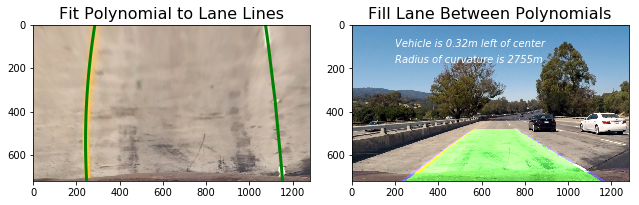

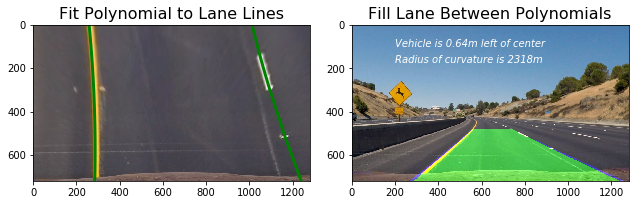

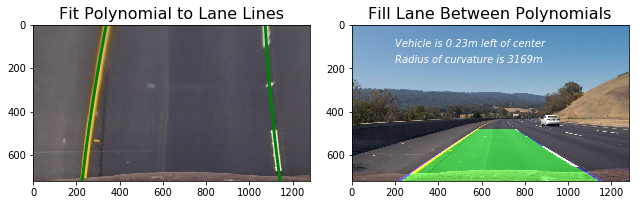

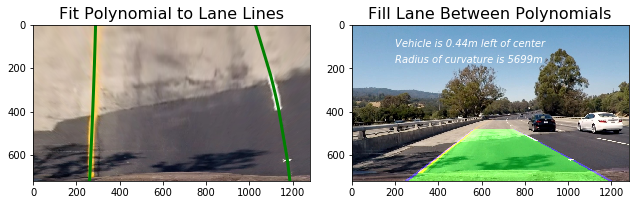

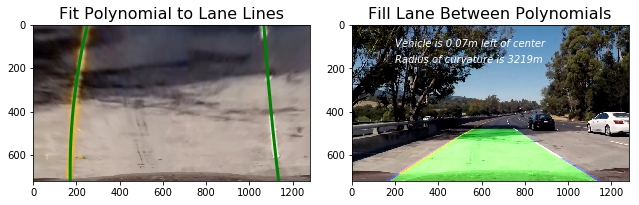

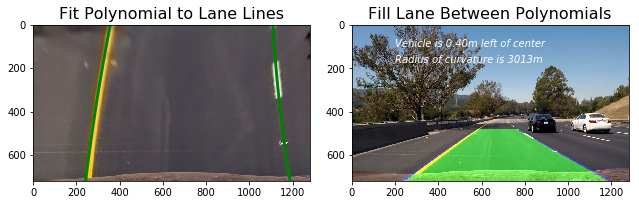

In [10]:
for image in glob.glob('test_images/test*.jpg'):
    full_lane(image)

In [11]:
class get_Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

Applying all features to the video through the video pipeline

In [12]:
# Video Processing Pipeline
def process_video(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],[1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        left_x, left_y, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        right_x, right_y, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        right_x, right_y, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        left_x, left_y, Left.found = Left.blind_search(x, y, combined_binary)

    left_y = np.array(left_y).astype(np.float32)
    left_x = np.array(left_x).astype(np.float32)
    right_y = np.array(right_y).astype(np.float32)
    right_x = np.array(right_x).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(left_y, left_x, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    left_x = np.append(left_x, leftx_int)
    left_y = np.append(left_y, 720)
    left_x = np.append(left_x, left_top)
    left_y = np.append(left_y, 0)
    
    # Sort detected pixels based on the yvals
    left_x, left_y = Left.sort_vals(left_x, left_y)
    
    Left.X = left_x
    Left.Y = left_y
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(left_y, left_x, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), np.mean(Left.fit1), np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(right_y, right_x, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(right_x, rightx_int)
    righty = np.append(right_y, 720)
    rightx = np.append(right_x, right_top)
    righty = np.append(right_y, 0)
    
    # Sort right lane pixels
    right_x, right_y = Right.sort_vals(right_x, right_y)
    Right.X = right_x
    Right.Y = right_y
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(right_y, right_x, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(left_x, left_y)
    right_curverad = Right.radius_of_curvature(right_x, right_y)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (right_x_int+left_x_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 15, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 15, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 15, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [13]:
Left = get_Line()
Right = get_Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")   
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [17:47<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [14]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [15]:
Left = get_Line()
Right = get_Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_video) 
challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [06:27<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [16]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))